In [18]:
import numpy as np
import scvi
import torch.nn
from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.dataloaders import AnnDataLoader
import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import pytorch_lightning as pl
import os
import sys
plt.style.use('default')
sys.path.append("../src")  # 将 src 目录添加到 Python 路径
import re
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="SpatialGCL")
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sim_adata = sc.read_h5ad('../data/Simulation/sim1.h5ad')
sim_adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    obsm: 'X_pca', 'X_umap'

### Generate Bulk Data

In [12]:
np.random.seed(0)
prop_pheno = 0.1
total_cell = 2000
n_bulk = 100
total_pheno = int(total_cell * prop_pheno)
total_non_pheno = total_cell - total_pheno
group1_idx = sim_adata[sim_adata.obs['Group'] == 'Group1'].obs_names
group2_idx = sim_adata[sim_adata.obs['Group'] == 'Group2'].obs_names
group3_idx = sim_adata[sim_adata.obs['Group'] == 'Group3'].obs_names

bulk1_group = []
bulk2_group = []
for i in range(n_bulk):
    pheno1_idx = np.random.choice(group2_idx, total_pheno, replace=True)
    pheno2_idx = np.random.choice(group3_idx, total_pheno, replace=True)
    non_pheno1_idx = np.random.choice(group1_idx, total_non_pheno, replace=True)
    non_pheno2_idx = np.random.choice(group1_idx, total_non_pheno, replace=True)
    bulk1_idx = np.concatenate([pheno1_idx, non_pheno1_idx])
    bulk2_idx = np.concatenate([pheno2_idx, non_pheno2_idx])
    bulk1 = sim_adata[bulk1_idx].X.mean(axis=0).astype(int)
    bulk2 = sim_adata[bulk2_idx].X.mean(axis=0).astype(int)
    bulk1_group.append(bulk1)
    bulk2_group.append(bulk2)
bulk1_group = np.array(bulk1_group)
bulk2_group = np.array(bulk2_group)
bulk_exp = np.concatenate([bulk1_group, bulk2_group], axis=0)
bulk_adata = sc.AnnData(X=bulk_exp)
bulk_adata.obs = pd.DataFrame({'Pheno': ['Pheno1']*n_bulk + ['Pheno2']*n_bulk})
bulk_adata.write_h5ad('../data/Simulation/sim1_bulk.h5ad')

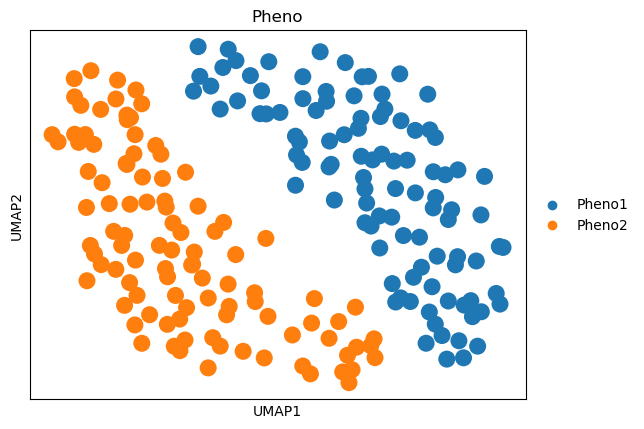

In [11]:
sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
sc.pp.scale(bulk_adata)
sc.pp.pca(bulk_adata)
sc.pp.neighbors(bulk_adata)
sc.tl.umap(bulk_adata)
sc.pl.umap(bulk_adata, color='Pheno')


### SCVI

In [3]:
bulk_adata = sc.read_h5ad('../data/Simulation/sim1_bulk.h5ad')

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
from model import ContrastiveAE
from dataset import ContrastiveDataModule
import pytorch_lightning as pl
data_module = ContrastiveDataModule(bulk_adata, label_key='Pheno', normalize=True, log1p=True)

In [326]:
model = ContrastiveAE(input_dim=500, latent_dim=64, hidden_dims=[256, 128], margin=2.0, label_key='Pheno')
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | encoder      | Encoder     | 170 K  | train
1 | decoder      | Decoder     | 170 K  | train
2 | triplet_loss | TripletLoss | 0      | train
3 | recon_loss   | MSELoss     | 0      | train
-----------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.363     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/home/DingchengYi/BulkPheno/scripts/../src/model.py:489: ImplicitModificationWarning: Setting element `.obsm['X_latent']` of view, initializing view as actual.
  if store_in_adata:


In [56]:
train_loader = data_module.train_dataloader()
for batch in train_loader:
    print(batch.keys())
    print(batch['anchor'].shape, batch['positive'].shape, batch['negative'].shape)
    print(batch)
    break


dict_keys(['anchor', 'positive', 'negative', 'label'])
torch.Size([128, 500]) torch.Size([128, 500]) torch.Size([128, 500])
{'anchor': tensor([[ 9.6873, 16.7961, 76.0682,  ...,  1.7569, 29.1414,  8.8375],
        [ 9.6916, 16.7998, 76.0052,  ...,  1.7584, 29.2911,  8.8418],
        [ 9.6652, 16.7662, 76.0557,  ...,  1.7514, 29.1052,  8.8168],
        ...,
        [ 9.6633, 16.7627, 76.0566,  ...,  1.7512, 29.0984,  8.8151],
        [ 9.7411, 16.8672, 75.9764,  ...,  1.7706, 29.0702,  8.8884],
        [ 9.6732, 16.7780, 76.0941,  ...,  1.7533, 29.1214,  8.8243]]), 'positive': tensor([[ 9.7573, 16.8907, 76.1189,  ...,  1.7743, 28.9478,  8.9035],
        [ 9.7444, 16.8722, 76.0227,  ...,  1.7713, 29.2302,  8.8915],
        [ 9.6334, 17.1550, 76.1137,  ...,  1.7438, 29.1996,  8.7869],
        ...,
        [ 9.6836, 16.7906, 76.0148,  ...,  1.7561, 29.1336,  8.8341],
        [ 9.6857, 17.2264, 76.0118,  ...,  1.7568, 29.1338,  8.8362],
        [ 9.6678, 16.7703, 76.1202,  ...,  1.7520, 29.2

In [5]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
model.eval()
z = []
for batch in train_loader:
    x = batch['expression']
    z.append(model.encoder(x).detach().numpy())
for batch in val_loader:
    x = batch['expression']
    z.append(model.encoder(x).detach().numpy())
z = np.concatenate(z)
z = pd.DataFrame(z)
z

KeyError: 'expression'

In [225]:
val_data = data_module.val_data
val_data.obs

Pheno
39   Pheno1
65   Pheno1
96   Pheno1
149  Pheno2
174  Pheno2
66   Pheno1
80   Pheno1
152  Pheno2
44   Pheno1
178  Pheno2
91   Pheno1
146  Pheno2
154  Pheno2
100  Pheno2
121  Pheno2
75   Pheno1
37   Pheno1
30   Pheno1
163  Pheno2
162  Pheno2

In [336]:
sc.pp.normalize_total(bulk_adata, target_sum=1e4)
sc.pp.log1p(bulk_adata)
bulk_adata.X

array([[0.84138006, 1.4583626 , 6.6001067 , ..., 0.15267451, 2.529418  ,
        0.7676145 ],
       [0.8452649 , 1.4635994 , 6.5926805 , ..., 0.15364283, 2.5224535 ,
        0.7712743 ],
       [0.84537864, 1.4637527 , 6.59538   , ..., 0.15367122, 2.5358787 ,
        0.7713815 ],
       ...,
       [0.83618754, 1.4513519 , 6.6032376 , ..., 0.15138464, 2.5210044 ,
        0.7627239 ],
       [0.8404802 , 1.4947864 , 6.6036735 , ..., 0.15245062, 2.527962  ,
        0.76676685],
       [0.83577096, 1.450789  , 6.600729  , ..., 0.15128139, 2.5333796 ,
        0.76233166]], dtype=float32)

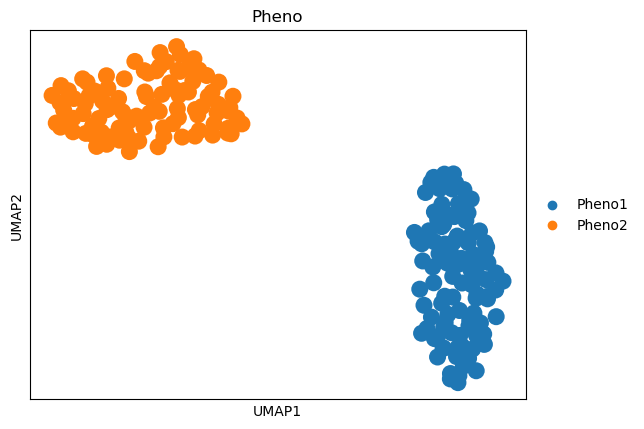

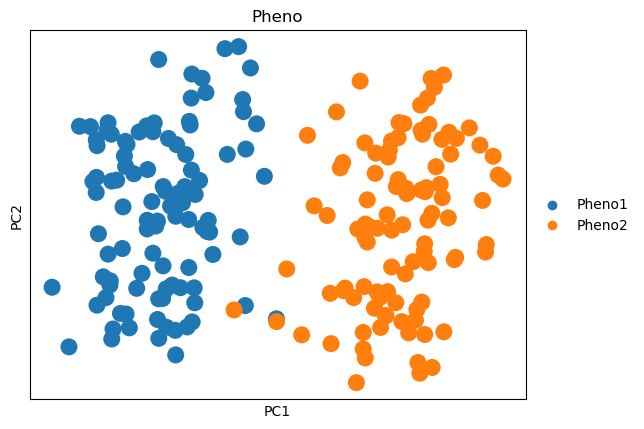

In [337]:
bulk_adata.obsm["X_scVI"] = model.get_latent_embedding(bulk_adata)

sc.pp.neighbors(bulk_adata, use_rep="X_scVI")
sc.tl.umap(bulk_adata)
sc.pp.pca(bulk_adata)
sc.pl.umap(bulk_adata, color='Pheno')
sc.pl.pca(bulk_adata, color='Pheno')

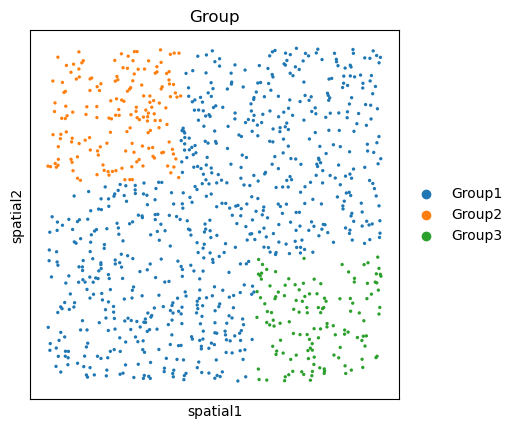

In [382]:
sim1a_adata = sc.read_h5ad('../data/Simulation/sim1_1a.h5ad')
sc.pl.spatial(sim1a_adata, color='Group', spot_size=0.01)

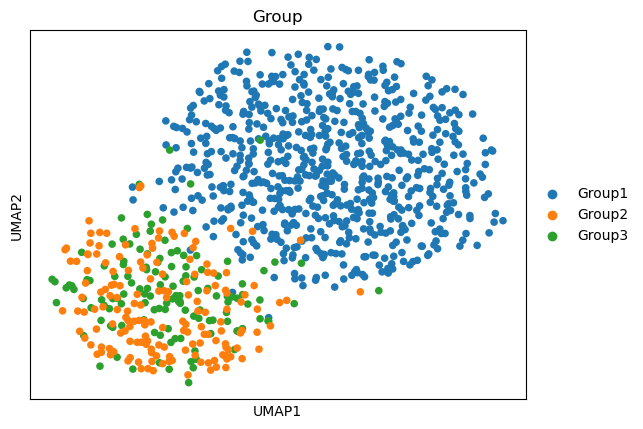

In [185]:
sc.pp.neighbors(sim1a_adata)
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color='Group')

In [383]:
sc.pp.neighbors(sim1a_adata, n_neighbors=20, use_rep='spatial')
sim1a_adata.obsp['spatial_connectivities'] = (sim1a_adata.obsp['distances'] > 0).astype(int)
sim1a_adata

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    uns: 'Group_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities', 'spatial_connectivities'

In [385]:
sim1a_adata.layers['counts'] = sim1a_adata.X.copy()
sim1a_adata.layers['niche_expression'] = (sim1a_adata.obsp['spatial_connectivities'] @ sim1a_adata.X / 19).astype(int)
sim1a_adata.X = sim1a_adata.layers['niche_expression']

In [386]:
sim1a_adata.layers['counts']

array([[   9,   20, 4613, ...,    2,   69,    7],
       [   8,   19, 4456, ...,    1,   68,   10],
       [   6,   24, 4702, ...,    1,   77,    7],
       ...,
       [   7,   19, 4006, ...,    2,   63,    8],
       [   8,   19, 4051, ...,    1,   67,    8],
       [   8,   17, 4201, ...,    1,   67,    8]])

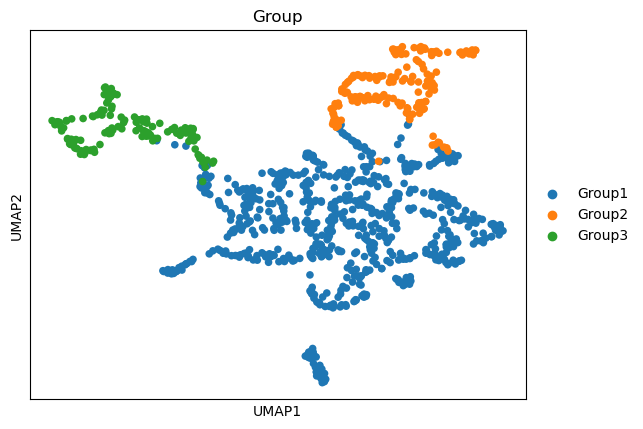

In [387]:
sim1a_adata.obsm['niche_expression'] = sim1a_adata.layers['niche_expression']
sc.pp.neighbors(sim1a_adata, use_rep='niche_expression')
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color='Group')

In [388]:
total_adata = sc.AnnData(X=np.concatenate([sim1a_adata.X, bulk_adata.X], axis=0), obs=pd.DataFrame({'Pheno': ['Unknown']*sim1a_adata.shape[0] + list(bulk_adata.obs['Pheno']), 'Group': sim1a_adata.obs['Group'].tolist() + list(bulk_adata.obs['Pheno'])}))
total_adata.obs['Pheno'] = total_adata.obs['Pheno'].astype(str)
total_adata.obs['Pheno'].replace({'nan': 'Unknown'}, inplace=True)
total_adata.obs

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_109358/3644891656.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  total_adata.obs['Pheno'].replace({'nan': 'Unknown'}, inplace=True)


Pheno   Group
0     Unknown  Group1
1     Unknown  Group1
2     Unknown  Group1
3     Unknown  Group1
4     Unknown  Group1
...       ...     ...
1195   Pheno2  Pheno2
1196   Pheno2  Pheno2
1197   Pheno2  Pheno2
1198   Pheno2  Pheno2
1199   Pheno2  Pheno2

[1200 rows x 2 columns]

In [333]:
total_adata.X

array([[   9,   20, 4613, ...,    2,   69,    7],
       [   8,   19, 4456, ...,    1,   68,   10],
       [   6,   24, 4702, ...,    1,   77,    7],
       ...,
       [   8,   20, 4506, ...,    1,   70,    7],
       [   8,   21, 4474, ...,    1,   70,    7],
       [   8,   20, 4498, ...,    1,   71,    7]])

In [ ]:
SCANVI.setup_anndata(total_adata, labels_key='Pheno', unlabeled_category='Unknown')
model_anvi = SCANVI.from_scvi_model(model, unlabeled_category='Unknown', labels_key='Pheno', adata=total_adata)
model_anvi.train(max_epochs=40)

total_adata.obsm["X_scanvi"] = model_anvi.get_latent_representation()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Training for 40 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/40 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


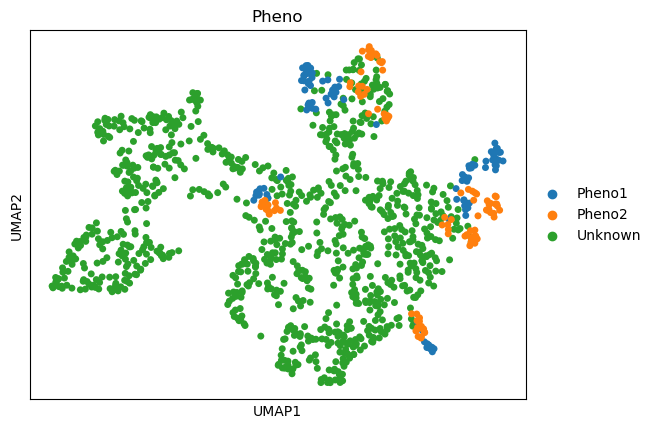

In [72]:
sc.pp.neighbors(total_adata, use_rep="X_scanvi")
sc.tl.umap(total_adata)
sc.pl.umap(total_adata, color='Pheno')

Pheno
0     Unknown
1     Unknown
2     Unknown
3     Unknown
4     Unknown
...       ...
1195   Pheno2
1196   Pheno2
1197   Pheno2
1198   Pheno2
1199   Pheno2

[1200 rows x 1 columns]

In [389]:
sc.pp.normalize_total(total_adata, target_sum=1e4)
sc.pp.log1p(total_adata)

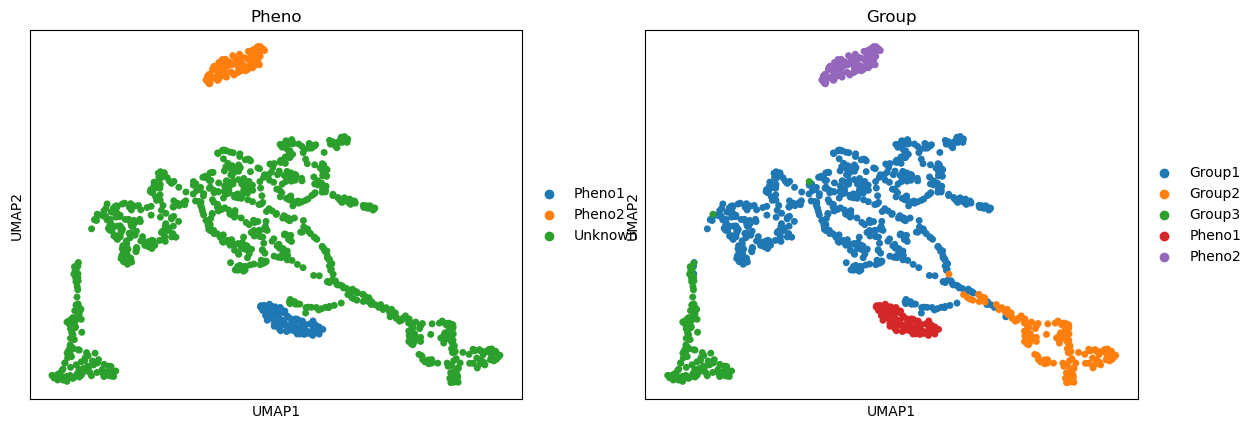

In [390]:
total_adata.obsm['X_con'] = model.get_latent_embedding(total_adata)
sc.pp.neighbors(total_adata, use_rep="X_con", n_neighbors=20)
sc.tl.umap(total_adata)
sc.pl.umap(total_adata, color=['Pheno', 'Group'])

In [297]:
np.median(total_adata[total_adata.obs['Group'] == 'Group3'].obsm['X_umap'], axis=0)

array([ 4.1832128, -2.1285963], dtype=float32)

In [293]:
((total_adata.obsm['X_umap'][:, 0] < 9) & (total_adata.obsm['X_umap'][:, 0] > 7)).sum()

58

<Axes: >

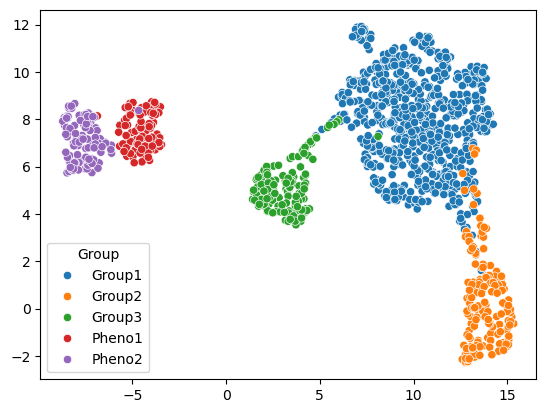

In [303]:
sns.scatterplot(x=total_adata.obsm['X_umap'][:, 0], y=total_adata.obsm['X_umap'][:, 1], hue=total_adata.obs['Group'])

In [318]:
interested_idx = total_adata[(total_adata.obsm['X_umap'][:, 0] < 6) & (total_adata.obsm['X_umap'][:, 1] > 6) & (total_adata.obsm['X_umap'][:, 0] > 4)].obs_names.astype(int)

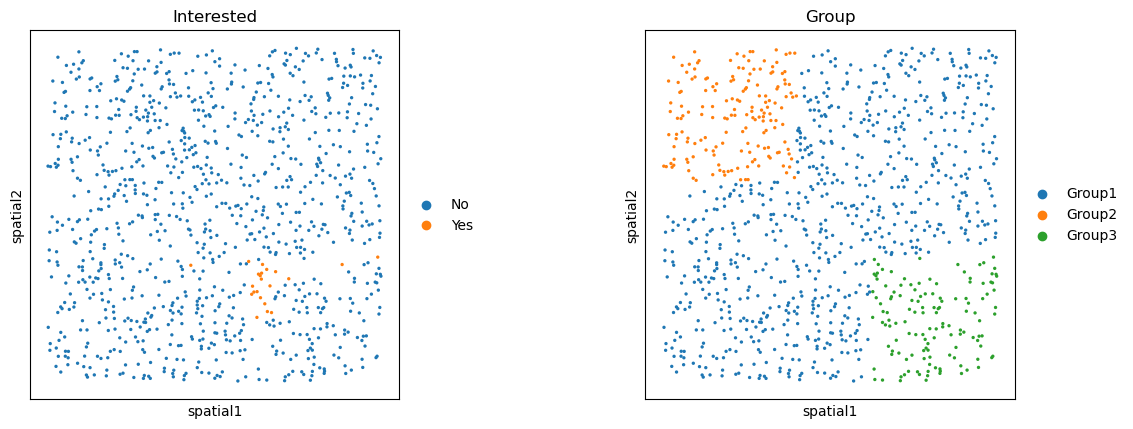

In [323]:
new_idx = sim1a_adata[interested_idx].obs_names
sim1a_adata.obs['Interested'] = 'No'
sim1a_adata.obs.loc[new_idx, 'Interested'] = 'Yes'
sc.pl.spatial(sim1a_adata, color=['Interested', 'Group'], spot_size=0.01)

In [397]:
queried = model.query_similar(total_adata, k = 25)
queried['labels']

[['Pheno1', 'Pheno2', 'Pheno2', 'Pheno1', 'Phen..., ['Pheno1', 'Pheno1', 'Pheno2', 'Pheno1', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno1', 'Pheno1', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno1', 'Pheno1', 'Pheno1', 'Pheno1', 'Phen..., ..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen..., ['Pheno2', 'Pheno2', 'Pheno2', 'Pheno2', 'Phen...]
Length: 1200
Categories (2, object): ['Pheno1', 'Pheno2']

In [345]:
queried

{'indices': array([[ 66,  44,  35, ...,  65,  76, 177],
        [ 73,  87, 179, ..., 115, 164,  66],
        [  9,  78, 114, ...,  50, 143,  97],
        ...,
        [  0,  36, 157, ..., 122, 150,  86],
        [162,  36, 141, ..., 172,  41,  58],
        [ 96, 120,  23, ...,  16,   7,   4]]),
 'distances': array([[0.99591374, 0.9957485 , 0.9957212 , ..., 0.99551713, 0.9955035 ,
         0.9954932 ],
        [0.99703133, 0.99699605, 0.99673367, ..., 0.9965786 , 0.996554  ,
         0.99652416],
        [0.99776745, 0.99775684, 0.9977407 , ..., 0.99759907, 0.9975879 ,
         0.99757254],
        ...,
        [1.        , 0.99981946, 0.9998053 , ..., 0.9997743 , 0.99977344,
         0.99977016],
        [1.        , 0.999825  , 0.9998022 , ..., 0.999722  , 0.99972135,
         0.9997153 ],
        [0.99987626, 0.99986887, 0.9998599 , ..., 0.9997854 , 0.9997824 ,
         0.99977976]], dtype=float32),
 'sample_ids': array([['88', '96', '82', ..., '100', '79', '166'],
        ['77', '97

In [347]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
df = pd.DataFrame(queried['labels'])
distance_df = pd.DataFrame(queried['distances'], columns=['Distance_'+str(i) for i in range(25)])
df['Group'] = total_adata.obs['Group'].values
df['Pheno'] = total_adata.obs['Pheno'].values
df = pd.concat([df, distance_df], axis=1)
df['Pheno2_count'] = df[list(range(25))].apply(lambda x: x.value_counts().iloc[0], axis=1)
df['Pheno3_count'] = df[list(range(25))].apply(lambda x: x.value_counts().iloc[1], axis=1)
df['Predicted'] = df[list(range(25))].apply(lambda x: x.value_counts().idxmax(), axis=1)
df

0       1       2       3       4       5       6       7       8  \
0     Pheno1  Pheno2  Pheno2  Pheno1  Pheno1  Pheno2  Pheno2  Pheno1  Pheno2   
1     Pheno1  Pheno1  Pheno2  Pheno1  Pheno1  Pheno2  Pheno1  Pheno2  Pheno2   
2     Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2   
3     Pheno1  Pheno1  Pheno2  Pheno2  Pheno1  Pheno2  Pheno2  Pheno2  Pheno1   
4     Pheno1  Pheno1  Pheno1  Pheno1  Pheno1  Pheno1  Pheno1  Pheno1  Pheno1   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1195  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2   
1196  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2   
1197  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2   
1198  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2   
1199  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2  Pheno2   

           9  ... Distance_18 Distance_19 Distance_20 Distance_21 Distance_22  \
0     Pheno1  ...    0.993565    0.993564    0.993559    0.993526    0.993523   
1     Pheno2  ...    0.997449    0.997446    0.997433    0.997433    0.997431   
2     Pheno2  ...    0.995931    0.995927    0.995921    0.995919    0.995916   
3     Pheno2  ...    0.997529    0.997522    0.997518    0.997515    0.997508   
4     Pheno1  ...    0.997684    0.997675    0.997664    0.997648    0.997645   
...      ...  ...         ...         ...         ...         ...         ...   
1195  Pheno2  ...    0.999695    0.999688    0.999679    0.999678    0.999676   
1196  Pheno2  ...    0.999685    0.999681    0.999681    0.999680    0.999674   
1197  Pheno2  ...    0.999706    0.999703    0.999699    0.999691    0.999689   
1198  Pheno2  ...    0.999674    0.999668    0.999667    0.999661    0.999651   
1199  Pheno2  ...    0.999751    0.999742    0.999738    0.999737    0.999736   

     Distance_23 Distance_24 Pheno2_count Pheno3_count Predicted  
0       0.993514    0.993484           17            8    Pheno2  
1       0.997423    0.997421           17            8    Pheno2  
2       0.995906    0.995903           18            7    Pheno2  
3       0.997505    0.997504           13           12    Pheno1  
4       0.997643    0.997643           25            0    Pheno1  
...          ...         ...          ...          ...       ...  
1195    0.999676    0.999674           25            0    Pheno2  
1196    0.999672    0.999671           25            0    Pheno2  
1197    0.999676    0.999676           25            0    Pheno2  
1198    0.999650    0.999650           25            0    Pheno2  
1199    0.999733    0.999726           25            0    Pheno2  

[1200 rows x 55 columns]

In [399]:
def calculate_avg_similarity(row):
    pheno1_sum = 0
    pheno2_sum = 0
    pheno1_count = 0
    pheno2_count = 0

    for i in range(25):
        if row[i] == 'Pheno1':
            pheno1_sum += row[f'Distance_{i}']
            pheno1_count += 1
        elif row[i] == 'Pheno2':
            pheno2_sum += row[f'Distance_{i}']
            pheno2_count += 1

    # 计算平均相似度
    avg_pheno1 = pheno1_sum / pheno1_count if pheno1_count > 0 else 0
    avg_pheno2 = pheno2_sum / pheno2_count if pheno2_count > 0 else 0

    return avg_pheno1, avg_pheno2

# 应用函数到每一行
df[['Avg_Similarity_Pheno1', 'Avg_Similarity_Pheno2']] = df.apply(
    lambda row: pd.Series(calculate_avg_similarity(row)), axis=1
)


In [395]:
pd.concat([sim1a_adata.obs,df.iloc[:1000][['Avg_Similarity_Pheno1', 'Avg_Similarity_Pheno2']]], axis=1)

Cell   Group    ExpLibSize  sizeFactor  Avg_Similarity_Pheno1  \
Cell630    Cell630  Group1  58382.309795    0.961584                    NaN   
Cell1584  Cell1584  Group1  70427.871672    1.169534                    NaN   
Cell1606  Cell1606  Group1  55845.632667    0.906677                    NaN   
Cell960    Cell960  Group1  56146.410243    0.922599                    NaN   
Cell597    Cell597  Group1  68871.728160    1.130074                    NaN   
...            ...     ...           ...         ...                    ...   
995            NaN     NaN           NaN         NaN               0.994710   
996            NaN     NaN           NaN         NaN               0.993317   
997            NaN     NaN           NaN         NaN               0.993633   
998            NaN     NaN           NaN         NaN               0.993442   
999            NaN     NaN           NaN         NaN               0.994889   

          Avg_Similarity_Pheno2  
Cell630                     NaN  
Cell1584                    NaN  
Cell1606                    NaN  
Cell960                     NaN  
Cell597                     NaN  
...                         ...  
995                         0.0  
996                         0.0  
997                         0.0  
998                         0.0  
999                         0.0  

[2000 rows x 6 columns]

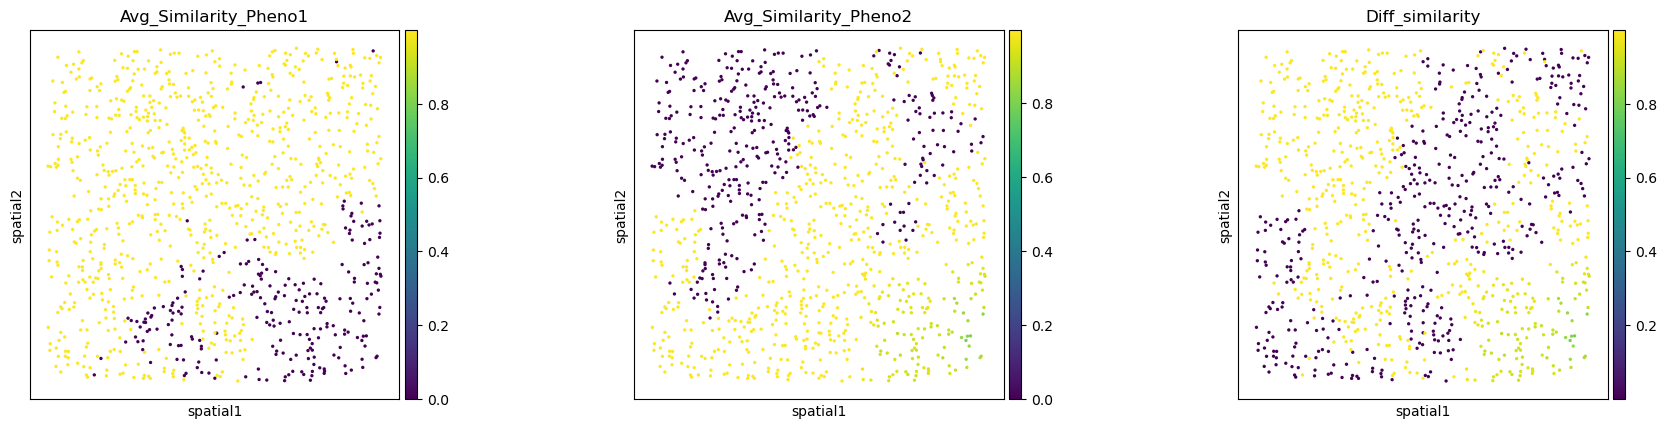

In [402]:
sim1a_adata.obs['Avg_Similarity_Pheno1'] = df.iloc[:1000]['Avg_Similarity_Pheno1'].values
sim1a_adata.obs['Avg_Similarity_Pheno2'] = df.iloc[:1000]['Avg_Similarity_Pheno2'].values
sim1a_adata.obs['Diff_similarity'] = abs(sim1a_adata.obs['Avg_Similarity_Pheno1'] - sim1a_adata.obs['Avg_Similarity_Pheno2'])
sc.pl.spatial(sim1a_adata, color=['Avg_Similarity_Pheno1', 'Avg_Similarity_Pheno2', 'Diff_similarity'], spot_size=0.01)

In [401]:
df.value_counts(['Predicted', 'Group'])

Predicted  Group 
Pheno1     Group1    354
Pheno2     Group1    348
Pheno1     Group2    166
Pheno2     Group3    132
Pheno1     Pheno1    100
Pheno2     Pheno2    100
Name: count, dtype: int64

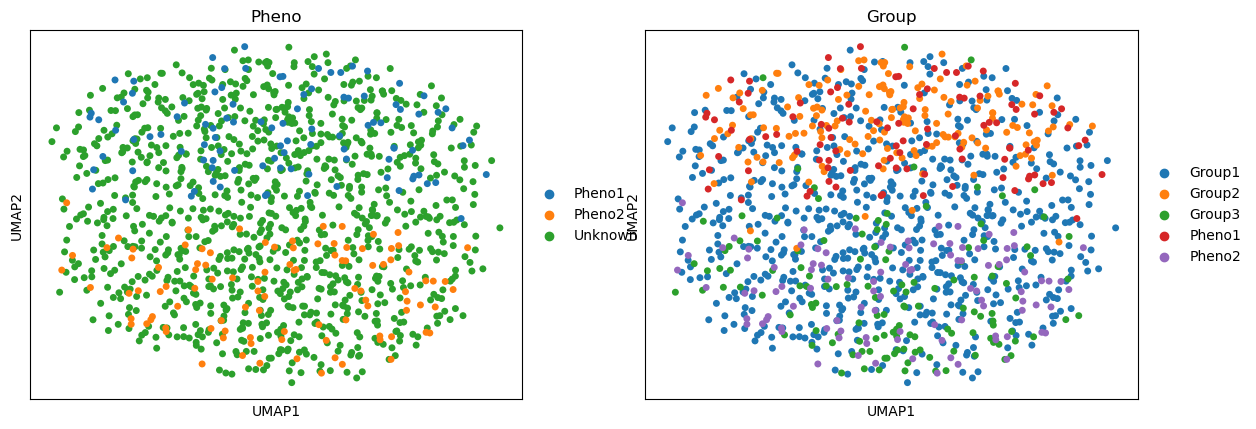

In [374]:
sc.pp.neighbors(total_adata, use_rep="X")
sc.tl.umap(total_adata)
sc.pl.umap(total_adata, color=['Pheno', 'Group'])

### Spatial Niche Embedding

In [2]:
from dataset import GraphContrastiveDataModule, SpatialGraphDataset
from torch_geometric.loader import DataLoader
from model import GraphContrastiveModel

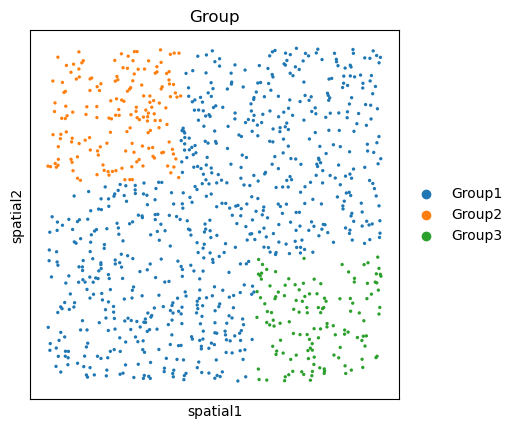

In [3]:
sim1a_adata = sc.read_h5ad('../data/Simulation/sim1_1a.h5ad')
sc.pl.spatial(sim1a_adata, color='Group', spot_size=0.01)

In [135]:
sc.pp.neighbors(sim1a_adata, n_neighbors=20, use_rep='spatial')
import scipy.sparse as sp
sim1a_adata.obsp['spatial_connectivities'] = sp.coo_matrix((sim1a_adata.obsp['distances'] > 0).astype(int))
sim1a_adata.obsp['spatial_distances'] = sim1a_adata.obsp['distances']
sim1a_adata

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    uns: 'Group_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [136]:
sc.pp.normalize_total(sim1a_adata, target_sum=1e4)
sc.pp.log1p(sim1a_adata)

In [ ]:

graph_dataset = SpatialGraphDataset(sim1a_adata, hops=2)
graph_dataset.len()

Processing...
Done!
/home/DingchengYi/BulkPheno/scripts/../src/dataset.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.process

1000

In [138]:
graph_dataset[0].edge_index

tensor([[ 0,  0,  0,  ..., 32, 32, 32],
        [ 2,  3,  6,  ..., 28, 30, 31]])

In [139]:
train_idx = np.random.choice(1000, int(graph_dataset.len() * 0.8), replace=False)
val_idx = np.setdiff1d(graph_dataset.indices(), train_idx)
train_dataset = graph_dataset[train_idx]
val_dataset = graph_dataset[val_idx]
print(len(train_dataset), len(val_dataset))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, follow_batch=['x', 'mean_expression'])
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, follow_batch=['x', 'mean_expression'])

800 200


In [152]:
graph_model = GraphContrastiveModel(input_dim=500, recon_weight=0.5, margin=0.8)
graph_trainer = pl.Trainer(max_epochs=50, logger=wandb_logger, log_every_n_steps=1)
graph_trainer.fit(graph_model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./SpatialGCL/fc534st1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | conv1        | GATConv        | 129 K  | train
1 | conv2        | GATConv        | 33.4 K | train
2 | decoder      | Sequential     | 161 K  | train
3 | triplet_loss | TripletGCLLoss | 0      | train
--------------------------------------------------------
324 K     Trainable params
0         Non-trainable params
324 K    

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
from networkx import center


z_emb = []
center_idxs = []
for batch in train_loader:
    print(batch)
    idxes = batch['center_node_idx']
    center_idxs.append(idxes)
    
    z = graph_model(batch)
    z_emb.append(z.detach().numpy())

for batch in val_loader:
    idxes = batch['center_node_idx']
    center_idxs.append(idxes)
    z = graph_model(batch)
    z_emb.append(z.detach().numpy())
    
    
z_emb = np.concatenate(z_emb, axis=0)
z_emb.shape
idxes = np.concatenate(center_idxs)
idxes.shape

DataBatch(x=[7464, 500], x_batch=[7464], x_ptr=[129], edge_index=[2, 109539], edge_attr=[109539], pos=[7464, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7464], ptr=[129])
DataBatch(x=[7694, 500], x_batch=[7694], x_ptr=[129], edge_index=[2, 114052], edge_attr=[114052], pos=[7694, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7694], ptr=[129])
DataBatch(x=[7534, 500], x_batch=[7534], x_ptr=[129], edge_index=[2, 111112], edge_attr=[111112], pos=[7534, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7534], ptr=[129])
DataBatch(x=[7252, 500], x_batch=[7252], x_ptr=[129], edge_index=[2, 105870], edge_attr=[105870], pos=[7252, 2], center_node_idx=[128], mean_expression=[64000], mean_expression_batch=[64000], mean_expression_ptr=[129], batch=[7252], ptr=[129])
DataBatch(x=[7681, 500],

(1000,)

In [143]:

pd.DataFrame(z_emb, index=idxes).sort_index().values

array([[-8.245471  , -1.0294173 ,  3.3660417 , ...,  2.1088502 ,
         0.46150953, -3.8432508 ],
       [-9.013973  , -0.33210218,  3.8229954 , ...,  1.7851157 ,
         0.35587204, -3.405281  ],
       [-9.0845175 , -0.6941881 ,  3.4168537 , ...,  2.723449  ,
         0.49098644, -3.5352228 ],
       ...,
       [-8.953124  ,  0.2554777 ,  3.5978386 , ..., -4.2374206 ,
         2.4297154 , -3.1909428 ],
       [-9.356766  ,  0.60997283,  3.641745  , ..., -4.043323  ,
         2.3514366 , -3.2834878 ],
       [-9.544421  ,  0.543336  ,  3.4719372 , ..., -4.2518797 ,
         2.4695382 , -3.151727  ]], dtype=float32)

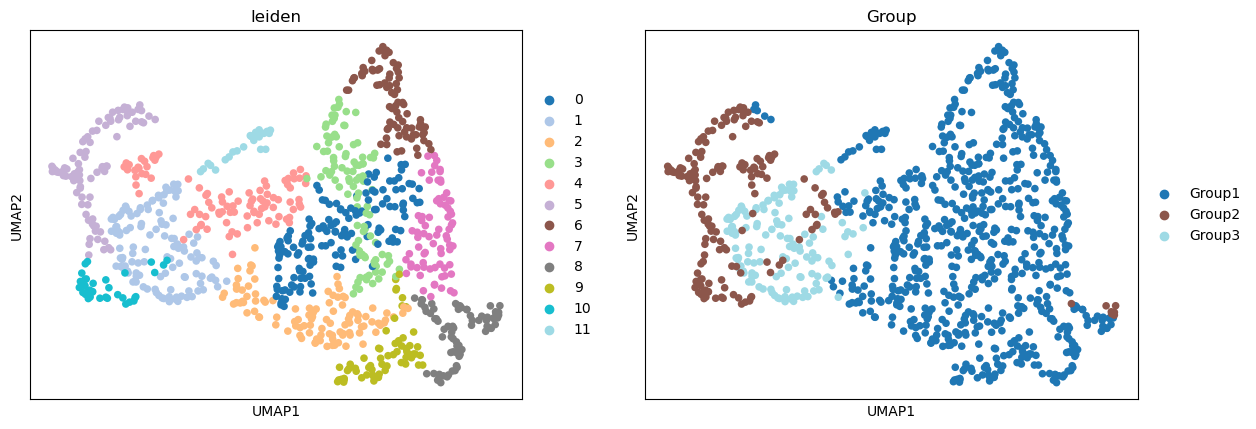

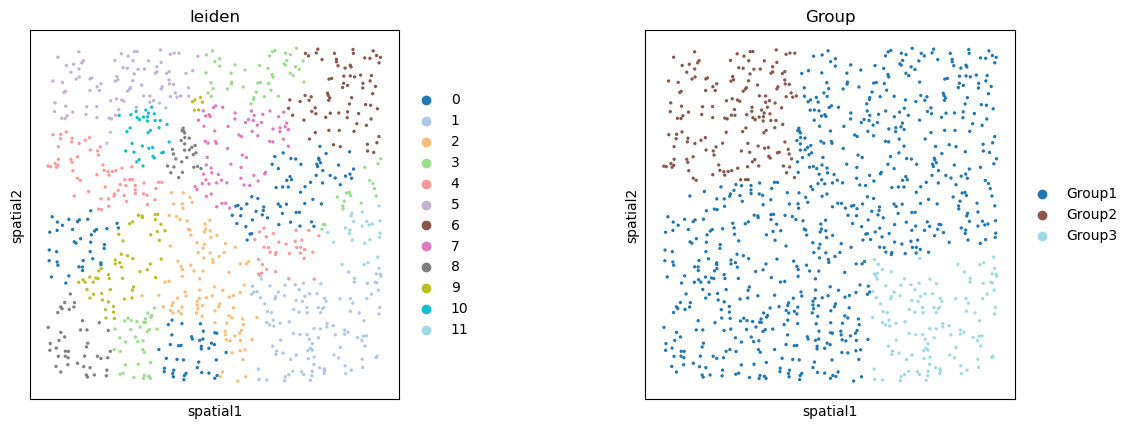

In [155]:
sim1a_adata.obsm['X_graph'] = pd.DataFrame(z_emb, index=idxes).sort_index().values
sc.pp.neighbors(sim1a_adata, use_rep='X_graph', n_neighbors=20)
sc.tl.leiden(sim1a_adata, resolution=0.5)
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color=['leiden', 'Group'], palette='tab20')
sc.pl.spatial(sim1a_adata, color=['leiden', 'Group'], spot_size=0.01, palette='tab20')

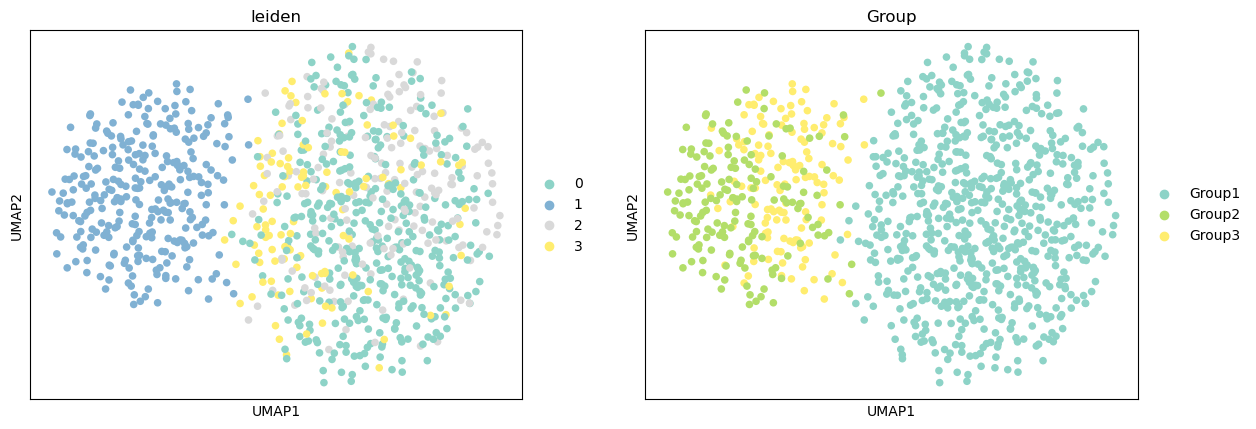

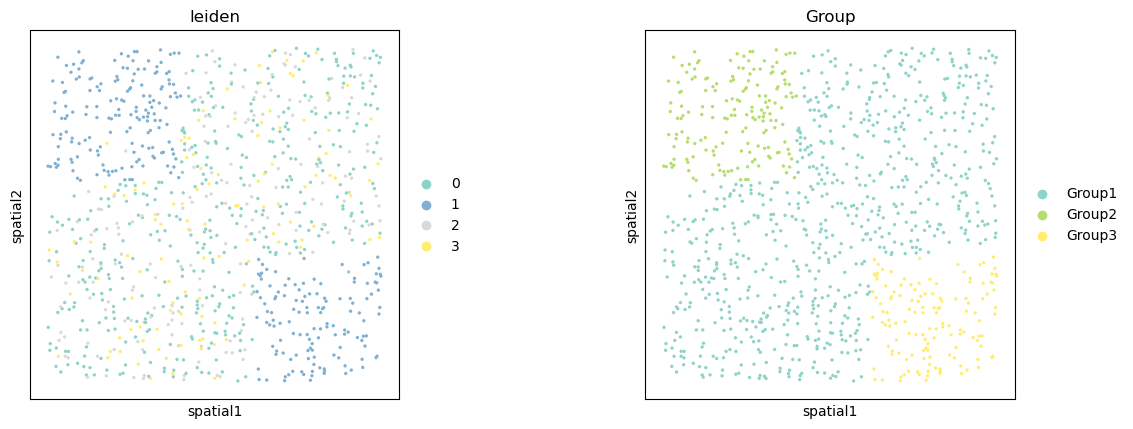

In [149]:
sc.pp.neighbors(sim1a_adata, use_rep='X', n_neighbors=20)
sc.tl.leiden(sim1a_adata, resolution=1.0)
sc.tl.umap(sim1a_adata)
sc.pl.umap(sim1a_adata, color=['leiden', 'Group'], palette='Set3')
sc.pl.spatial(sim1a_adata, color=['leiden', 'Group'], spot_size=0.01, palette='Set3')

#### HCC MERFISH

In [4]:
HCC = sc.read_h5ad('../data/MERFISH/HC1_processed.h5ad')
HCC

AnnData object with n_obs × n_vars = 480592 × 500
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cell_type', 'sub_cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'sub_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [22]:
HCC.obsm['spatial'].max(axis=0), HCC.obsm['spatial'].min(axis=0)

(array([11629.73828988,  8814.18020007]),
 array([ -75.62139597, -111.33519535]))

<Axes: >

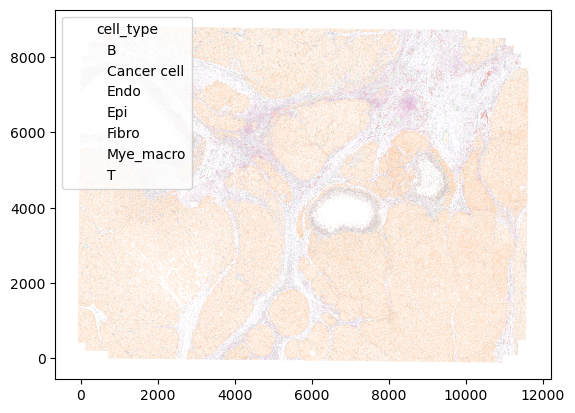

In [6]:
sns.scatterplot(x=HCC.obsm['spatial'][:, 0], y=HCC.obsm['spatial'][:, 1], hue=HCC.obs['cell_type'], s=0.03)

In [9]:
use_region = HCC[(HCC.obsm['spatial'][:, 0] < 5500) & (HCC.obsm['spatial'][:, 0] > 4000) & (HCC.obsm['spatial'][:, 1] < 2000) & (HCC.obsm['spatial'][:, 1] > 0)].copy()
use_region

AnnData object with n_obs × n_vars = 14971 × 500
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cell_type', 'sub_cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'sub_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

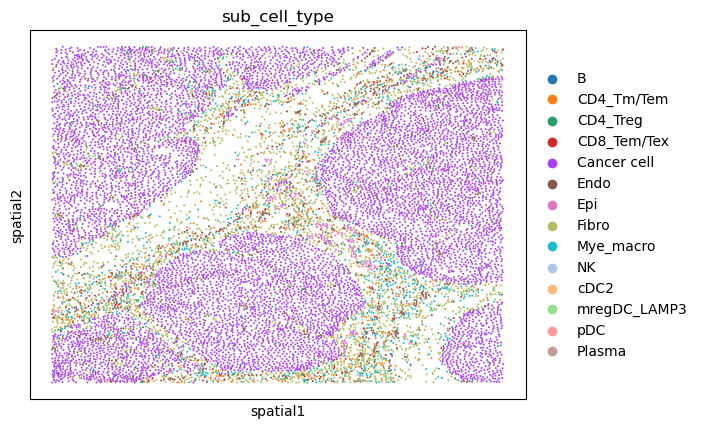

In [10]:
sc.pl.embedding(use_region, basis='spatial',  color='sub_cell_type')

In [12]:

sc.pp.neighbors(use_region, n_neighbors=20, use_rep='spatial')
import scipy.sparse as sp
use_region.obsp['spatial_connectivities'] = sp.coo_matrix((use_region.obsp['distances'] > 0).astype(int))
use_region.obsp['spatial_distances'] = use_region.obsp['distances']
graph_dataset = SpatialGraphDataset(use_region, name='region_2b', hops=2)
graph_dataset.len()

Processing...
100%|██████████| 14971/14971 [00:17<00:00, 836.42it/s]
Done!
/home/DingchengYi/BulkPheno/scripts/../src/dataset.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

14971

In [19]:

train_idx = np.random.choice(14971, int(graph_dataset.len() * 0.8), replace=False)
val_idx = np.setdiff1d(graph_dataset.indices(), train_idx)
train_dataset = graph_dataset[train_idx]
val_dataset = graph_dataset[val_idx]
print(len(train_dataset), len(val_dataset))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, follow_batch=['x', 'mean_expression'])
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, follow_batch=['x', 'mean_expression'])

11976 2995


In [20]:
graph_model = GraphContrastiveModel(input_dim=500, latent_dim=32, recon_weight=0.8, margin=1.0)
graph_trainer = pl.Trainer(max_epochs=10, logger=wandb_logger, log_every_n_steps=1)
graph_trainer.fit(graph_model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: purkinje_cell (purkinje_cell-pku) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | conv1        | GATConv        | 129 K  | train
1 | conv2        | GATConv        | 8.4 K  | train
2 | decoder      | Sequential     | 136 K  | train
3 | triplet_loss | TripletGCLLoss | 0      | train
--------------------------------------------------------
274 K     Trainable params
0         Non-trainable params
274 K     Total params
1.098     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:

z_emb = []
center_idxs = []
for batch in train_loader:
    print(batch)
    idxes = batch['center_node_idx']
    center_idxs.append(idxes)
    
    z = graph_model(batch)
    z_emb.append(z.detach().numpy())

for batch in val_loader:
    idxes = batch['center_node_idx']
    center_idxs.append(idxes)
    z = graph_model(batch)
    z_emb.append(z.detach().numpy())
    
    
z_emb = np.concatenate(z_emb, axis=0)
z_emb.shape
idxes = np.concatenate(center_idxs)
idxes.shape


DataBatch(x=[34521, 500], x_batch=[34521], x_ptr=[513], edge_index=[2, 526927], edge_attr=[526927], pos=[34521, 2], center_node_idx=[512], mean_expression=[256000], mean_expression_batch=[256000], mean_expression_ptr=[513], batch=[34521], ptr=[513])
DataBatch(x=[34403, 500], x_batch=[34403], x_ptr=[513], edge_index=[2, 523677], edge_attr=[523677], pos=[34403, 2], center_node_idx=[512], mean_expression=[256000], mean_expression_batch=[256000], mean_expression_ptr=[513], batch=[34403], ptr=[513])
DataBatch(x=[34325, 500], x_batch=[34325], x_ptr=[513], edge_index=[2, 524829], edge_attr=[524829], pos=[34325, 2], center_node_idx=[512], mean_expression=[256000], mean_expression_batch=[256000], mean_expression_ptr=[513], batch=[34325], ptr=[513])
DataBatch(x=[34713, 500], x_batch=[34713], x_ptr=[513], edge_index=[2, 531830], edge_attr=[531830], pos=[34713, 2], center_node_idx=[512], mean_expression=[256000], mean_expression_batch=[256000], mean_expression_ptr=[513], batch=[34713], ptr=[513])


(14971,)

/tmp/ipykernel_8618/2232148549.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(use_region, resolution=0.5)


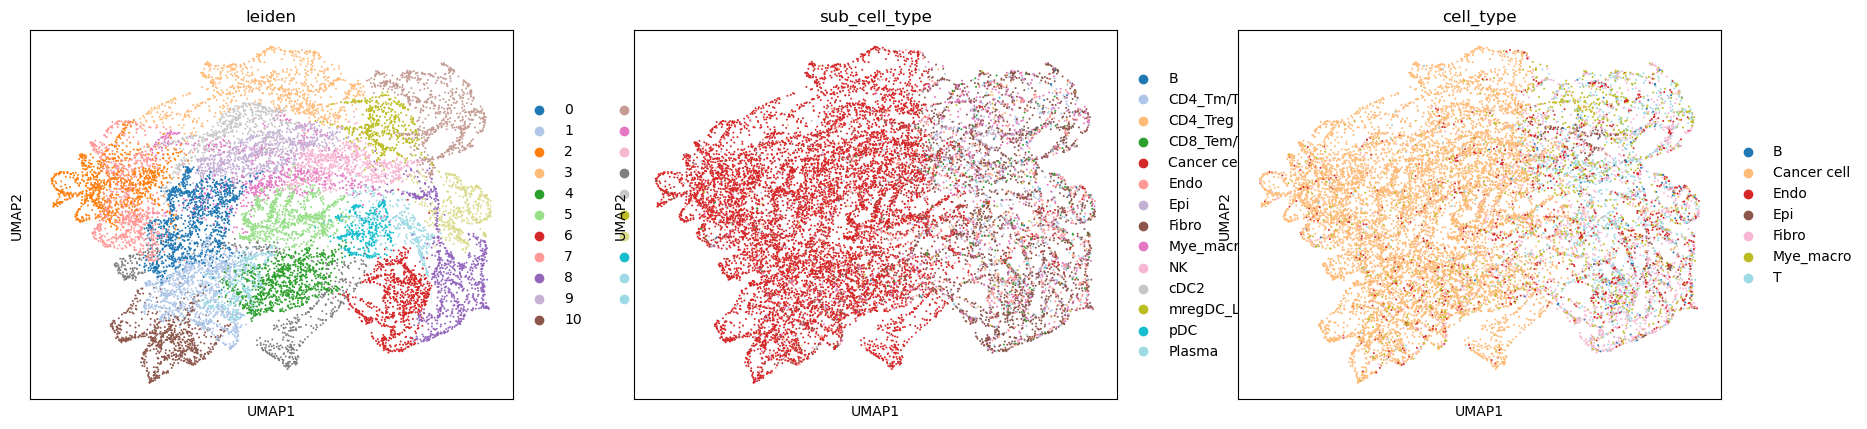

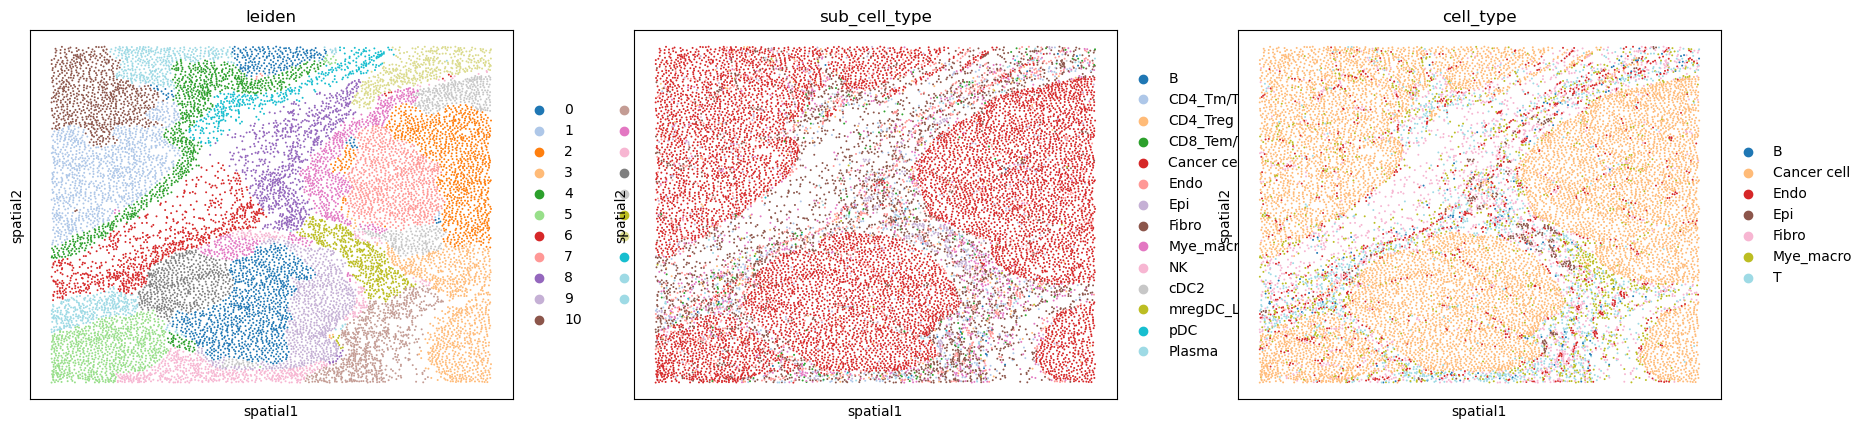

In [22]:
use_region.obsm['X_graph'] = pd.DataFrame(z_emb, index=idxes).sort_index().values
sc.pp.neighbors(use_region, use_rep='X_graph', n_neighbors=20)
sc.tl.leiden(use_region, resolution=0.5)
sc.tl.umap(use_region)
sc.pl.umap(use_region, color=['leiden', 'sub_cell_type', 'cell_type'], palette='tab20')
sc.pl.embedding(use_region, basis='spatial', color=['leiden', 'sub_cell_type', 'cell_type'], palette='tab20')

In [25]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='emb_pca', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata
use_region = mclust_R(use_region, 5, modelNames='EEE', used_obsm='X_graph')

fitting ...
  |======================================================================| 100%


In [13]:
use_region

AnnData object with n_obs × n_vars = 12718 × 500
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cell_type', 'sub_cell_type', 'mclust'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'sub_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial', 'X_graph'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

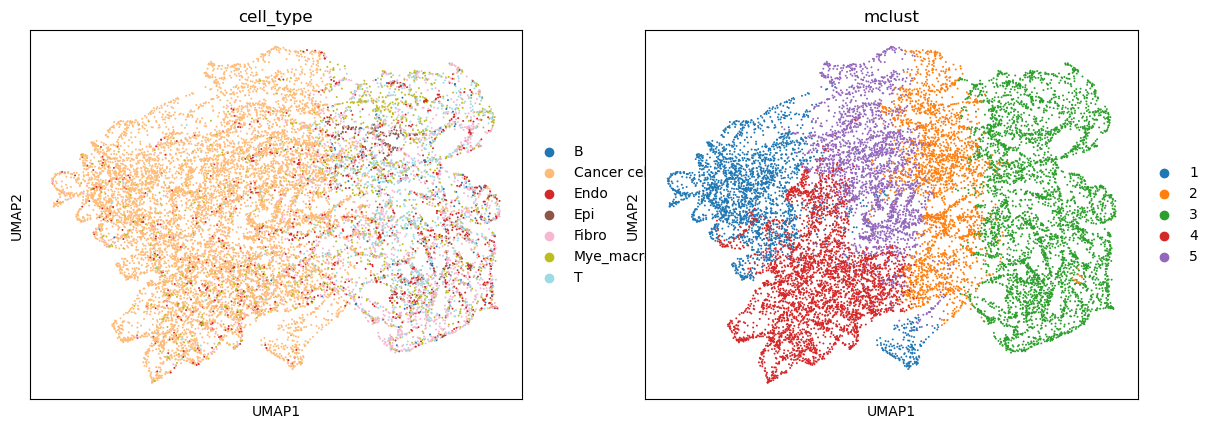

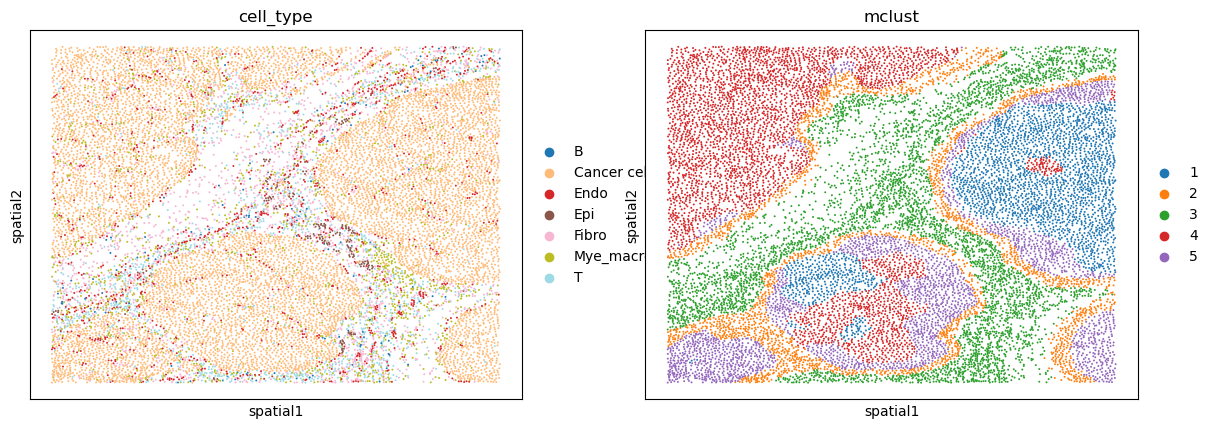

In [26]:

# sc.tl.umap(use_region)
sc.pl.umap(use_region, color=[ 'cell_type', 'mclust'])
sc.pl.embedding(use_region, basis='spatial', color=['cell_type', 'mclust'], save='mclust2.pdf')

In [29]:
graph_model.build_similarity_index(train_loader)

Built similarity index with 11976 embeddings


In [ ]:
val_idx = 500
test_embeddings = graph_model(val_dataset[val_idx])
test_embeddings.mean(axis=0).shape

query_res = graph_model.embedding_store.query(test_embeddings.mean(axis=0).reshape(1, -1).detach().cpu().numpy(), k=5000)
# query_res = query_res
query_res['distances'] = query_res['distances'].flatten()
query_res['indices'] = query_res['indices'].flatten()
query_res['sample_ids'] = query_res['sample_ids'].flatten()
del query_res['labels']
query_res = pd.DataFrame(query_res).query('distances > 0.9')
query_res
# val_dataset[0].center_node_idx

indices  distances  sample_ids
0       3115   0.989532        1481
1       4209   0.981128        1504
2      11455   0.977690        1498
3       3366   0.975193        1491
4       2405   0.973075         794
..       ...        ...         ...
489     7629   0.900498        5306
490     2101   0.900298       14030
491     3801   0.900269        3560
492     4072   0.900180        7529
493     8550   0.900100        2454

[494 rows x 3 columns]

In [70]:
use_region.obsp['spatial_connectivities'] = sp.csr_matrix(use_region.obsp['spatial_connectivities'])

In [104]:
val_dataset[100].center_node_idx.numpy()

array([566])

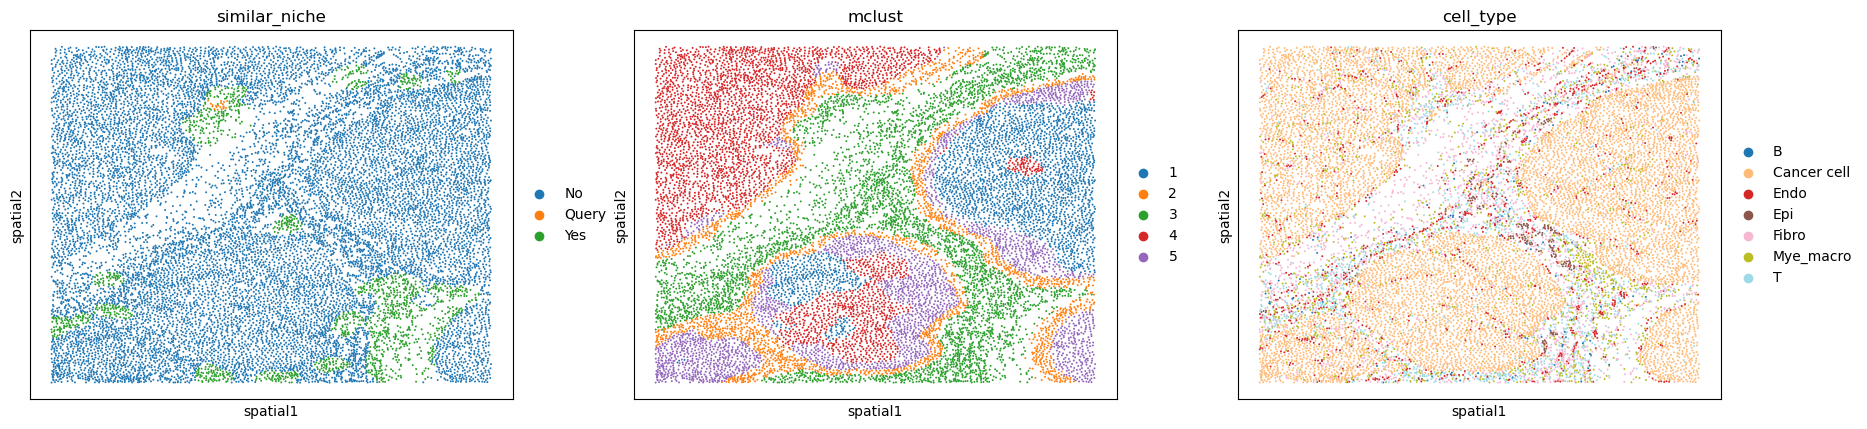

In [110]:
query_center = use_region[val_dataset[100].center_node_idx.numpy()].obs_names
query_niche_idx = use_region.obsp['spatial_connectivities'][val_dataset[val_idx].center_node_idx.numpy()].nonzero()[1]
query_niche_idx
query_niche_idx = np.unique(query_niche_idx)
query_niche = use_region.obs_names[query_niche_idx]
similar_niche_center = use_region[query_res['sample_ids']].obs_names
similar_niche_idx = use_region.obsp['spatial_connectivities'][query_res['sample_ids']].nonzero()[1]
similar_niche_idx = np.unique(similar_niche_idx)
similar_niche = use_region.obs_names[similar_niche_idx]

use_region.obs['similar_niche'] = 'No'
use_region.obs.loc[similar_niche, 'similar_niche'] = 'Yes'
use_region.obs.loc[query_niche, 'similar_niche'] = 'Query'
sc.pl.embedding(use_region, basis='spatial', color=['similar_niche', 'mclust', 'cell_type'])